# Context:
A Non-Banking Finance Company  is an online platform committed to delivering customized loan products to millennials.
They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.
The data science team is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

#### Company deploys formal credit to salaried individuals and businesses 4 main financial instruments:

- Personal Loan
- EMI Free Loan
- Personal Overdraft
- Advance Salary Loan

### This case study will focus on the underwriting process behind Personal Loan only

# Problem Statement:

Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?
Tradeoff Questions:
How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone

### Data dictionary:
- loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- term : The number of payments on the loan. Values are in months and can be either 36 or 60.
- int_rate : Interest Rate on the loan
- installment : The monthly payment owed by the borrower if the loan originates.
- grade : Institution assigned loan grade
- sub_grade : Institution assigned loan subgrade
- emp_title :The job title supplied by the Borrower when applying for the loan.*
- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
- annual_inc : The self-reported annual income provided by the borrower during registration.
- verification_status : Indicates if income was verified by Institution, not verified, or if the income source was verified
- issue_d : The month which the loan was funded
- loan_status : Current status of the loan - Target Variable
- purpose : A category provided by the borrower for the loan request.
- title : The loan title provided by the borrower
- dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested Institution loan, divided by the borrower’s self-reported monthly income.
- earliest_cr_line :The month the borrower's earliest reported credit line was opened
- open_acc : The number of open credit lines in the borrower's credit file.
- pub_rec : Number of derogatory public records
- revol_bal : Total credit revolving balance
- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- total_acc : The total number of credit lines currently in the borrower's credit file
- initial_list_status : The initial listing status of the loan. Possible values are – W, F
- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
- mort_acc : Number of mortgage accounts.
- pub_rec_bankruptcies : Number of public record bankruptcies
- Address: Address of the individual

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, auc, ConfusionMatrixDisplay, RocCurveDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

In [89]:
# Reading the data
data=pd.read_csv('loan.csv')
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [14]:
# Shape of the dataset
print("No. of rows : ",data.shape[0])
print("No. of columns : ",data.shape[1])

No. of rows :  396030
No. of columns :  27


In [6]:
# Checking the distribution of the outcome labels
data.loan_status.value_counts(normalize=True)*100

Fully Paid     80.387092
Charged Off    19.612908
Name: loan_status, dtype: float64

In [7]:
# Statistical summary of the dataset
data.describe(include='all')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
count,396030.000000,396030,396030.000000,396030.000000,396030,396030,373103,377729,396030,3.960300e+05,...,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,396030,396030,358235.000000,395495.000000,396030
unique,NaN,2,NaN,NaN,7,35,173105,11,6,NaN,...,NaN,NaN,NaN,NaN,NaN,2,3,NaN,NaN,393700
top,NaN,36 months,NaN,NaN,B,B3,Teacher,10+ years,MORTGAGE,NaN,...,NaN,NaN,NaN,NaN,NaN,f,INDIVIDUAL,NaN,NaN,USCGC Smith\r\nFPO AE 70466
freq,NaN,302005,NaN,NaN,116018,26655,4389,126041,198348,NaN,...,NaN,NaN,NaN,NaN,NaN,238066,395319,NaN,NaN,8
mean,14113.888089,NaN,13.639400,431.849698,NaN,NaN,NaN,NaN,NaN,7.420318e+04,...,11.311153,0.178191,1.584454e+04,53.791749,25.414744,NaN,NaN,1.813991,0.121648,NaN
std,8357.441341,NaN,4.472157,250.727790,NaN,NaN,NaN,NaN,NaN,6.163762e+04,...,5.137649,0.530671,2.059184e+04,24.452193,11.886991,NaN,NaN,2.147930,0.356174,NaN
min,500.000000,NaN,5.320000,16.080000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,2.000000,NaN,NaN,0.000000,0.000000,NaN
25%,8000.000000,NaN,10.490000,250.330000,NaN,NaN,NaN,NaN,NaN,4.500000e+04,...,8.000000,0.000000,6.025000e+03,35.800000,17.000000,NaN,NaN,0.000000,0.000000,NaN
50%,12000.000000,NaN,13.330000,375.430000,NaN,NaN,NaN,NaN,NaN,6.400000e+04,...,10.000000,0.000000,1.118100e+04,54.800000,24.000000,NaN,NaN,1.000000,0.000000,NaN
75%,20000.000000,NaN,16.490000,567.300000,NaN,NaN,NaN,NaN,NaN,9.000000e+04,...,14.000000,0.000000,1.962000e+04,72.900000,32.000000,NaN,NaN,3.000000,0.000000,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [78]:
data.nunique()

loan_amnt                               1385
term                                       2
int_rate                                 502
annual_inc                             22685
loan_status                                2
dti                                     4038
open_acc                                  26
pub_rec                                    2
revol_bal                              48276
revol_util                              1196
total_acc                                 58
initial_list_status                        2
mort_acc                                   2
pub_rec_bankruptcies                       2
purpose_credit_card                        2
purpose_debt_consolidation                 2
purpose_educational                        2
purpose_home_improvement                   2
purpose_house                              2
purpose_major_purchase                     2
purpose_medical                            2
purpose_moving                             2
purpose_ot

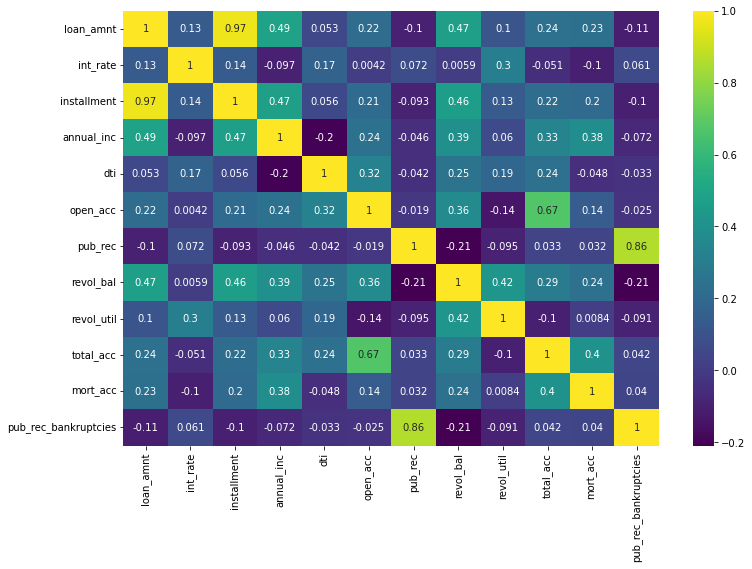

In [9]:
import warnings
warnings.filterwarnings("ignore")
# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(method='spearman'),annot=True,cmap='viridis')
plt.show()

We noticed almost perfect correlation between "loan_amnt" the "installment" feature. 

- installment: The monthly payment owed by the borrower if the loan originates.
- loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

So, we can drop either one of those columns.

In [15]:
data.drop(columns=['installment'],axis=1,inplace=True)

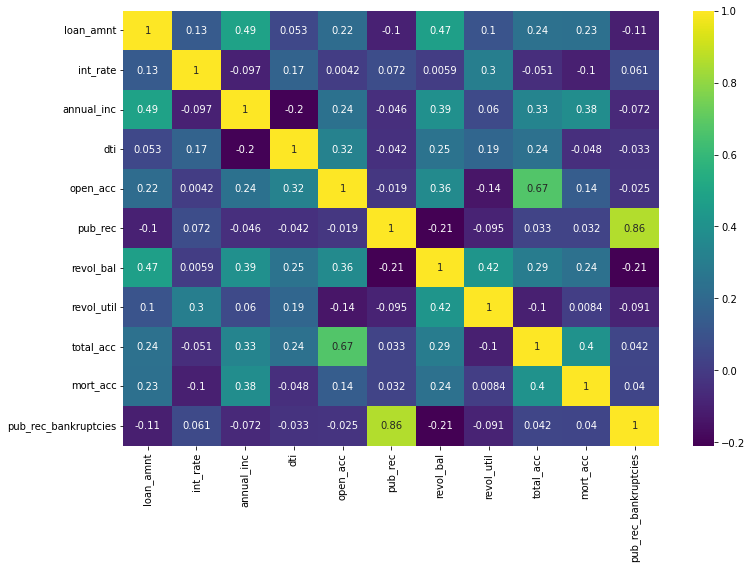

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

## Data Exploration

1. The no. of people who have paid fully and the no. of people who are charged off

In [17]:
data.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


2. The majority of ownership as Mortgage and Rent

In [18]:
data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

3. Combining the minority classes as 'OTHERS'

In [19]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

In [20]:
data['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: home_ownership, dtype: int64

In [21]:
# Checking the distribution of 'Other'
data.loc[data['home_ownership']=='OTHER','loan_status'].value_counts()

Fully Paid     123
Charged Off     23
Name: loan_status, dtype: int64

4. Converting string to date-time format

In [22]:
data['issue_d']=pd.to_datetime(data['issue_d'])
data['earliest_cr_line']=pd.to_datetime(data['earliest_cr_line'])

5. Saw some issues in title(Looks like it was filled manually and needs some fixing).

In [23]:
data['title'].value_counts()[:20]

Debt consolidation           152472
Credit card refinancing       51487
Home improvement              15264
Other                         12930
Debt Consolidation            11608
Major purchase                 4769
Consolidation                  3852
debt consolidation             3547
Business                       2949
Debt Consolidation Loan        2864
Medical expenses               2742
Car financing                  2139
Credit Card Consolidation      1775
Vacation                       1717
Moving and relocation          1689
consolidation                  1595
Personal Loan                  1591
Consolidation Loan             1299
Home Improvement               1268
Home buying                    1183
Name: title, dtype: int64

In [24]:
data['title']=data.title.str.lower()

In [25]:
data['title'].value_counts()[:20]

debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
personal loan                  2460
car financing                  2160
credit card payoff             1904
consolidation loan             1887
vacation                       1866
credit card refinance          1832
moving and relocation          1693
consolidate                    1528
personal                       1465
home buying                    1196
Name: title, dtype: int64

<AxesSubplot: xlabel='loan_status', ylabel='loan_amnt'>

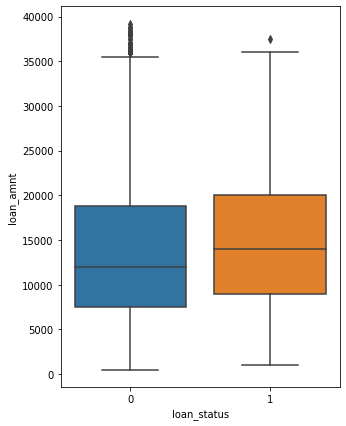

In [79]:
plt.figure(figsize=(5,7))
sns.boxplot(y=data["loan_amnt"],
            x=data["loan_status"])

<AxesSubplot: xlabel='loan_amnt', ylabel='Count'>

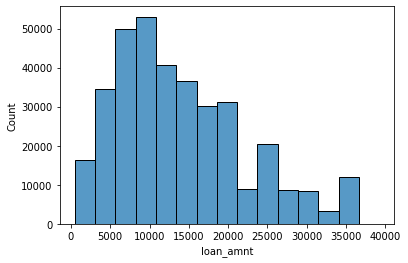

In [80]:
sns.histplot(data["loan_amnt"],bins = 15)

In [81]:
data.groupby(by = "loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,286293.0,13.075118,4.266280,5.32,9.99,12.99,15.610,26.99
1,68226.0,15.876401,4.312881,5.32,12.99,15.61,18.635,26.99


<AxesSubplot: xlabel='int_rate', ylabel='Count'>

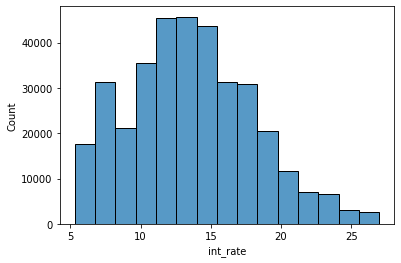

In [83]:
sns.histplot(data["int_rate"],bins = 15)

## Visualization

The grade of majority of people those who have fully paid the loan is 'B' and have subgrade 'B3'.

So from that we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan.

[Text(0, 0, 'A1'),
 Text(1, 0, 'A2'),
 Text(2, 0, 'A3'),
 Text(3, 0, 'A4'),
 Text(4, 0, 'A5'),
 Text(5, 0, 'B1'),
 Text(6, 0, 'B2'),
 Text(7, 0, 'B3'),
 Text(8, 0, 'B4'),
 Text(9, 0, 'B5'),
 Text(10, 0, 'C1'),
 Text(11, 0, 'C2'),
 Text(12, 0, 'C3'),
 Text(13, 0, 'C4'),
 Text(14, 0, 'C5'),
 Text(15, 0, 'D1'),
 Text(16, 0, 'D2'),
 Text(17, 0, 'D3'),
 Text(18, 0, 'D4'),
 Text(19, 0, 'D5'),
 Text(20, 0, 'E1'),
 Text(21, 0, 'E2'),
 Text(22, 0, 'E3'),
 Text(23, 0, 'E4'),
 Text(24, 0, 'E5'),
 Text(25, 0, 'F1'),
 Text(26, 0, 'F2'),
 Text(27, 0, 'F3'),
 Text(28, 0, 'F4'),
 Text(29, 0, 'F5'),
 Text(30, 0, 'G1'),
 Text(31, 0, 'G2'),
 Text(32, 0, 'G3'),
 Text(33, 0, 'G4'),
 Text(34, 0, 'G5')]

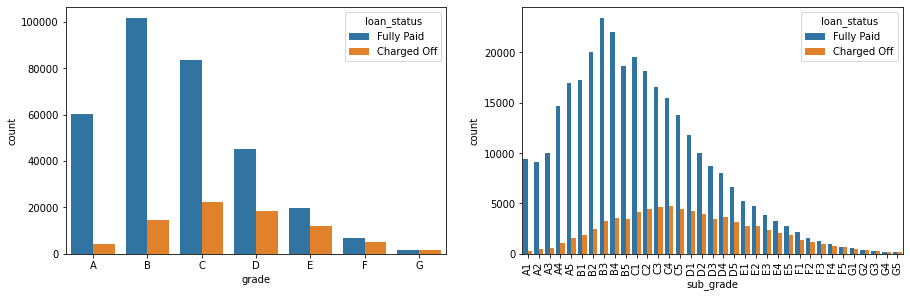

In [26]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

[Text(0, 0, 'vacation'),
 Text(1, 0, 'debt_consolidation'),
 Text(2, 0, 'credit_card'),
 Text(3, 0, 'home_improvement'),
 Text(4, 0, 'small_business'),
 Text(5, 0, 'major_purchase'),
 Text(6, 0, 'other'),
 Text(7, 0, 'medical'),
 Text(8, 0, 'wedding'),
 Text(9, 0, 'car'),
 Text(10, 0, 'moving'),
 Text(11, 0, 'house'),
 Text(12, 0, 'educational'),
 Text(13, 0, 'renewable_energy')]

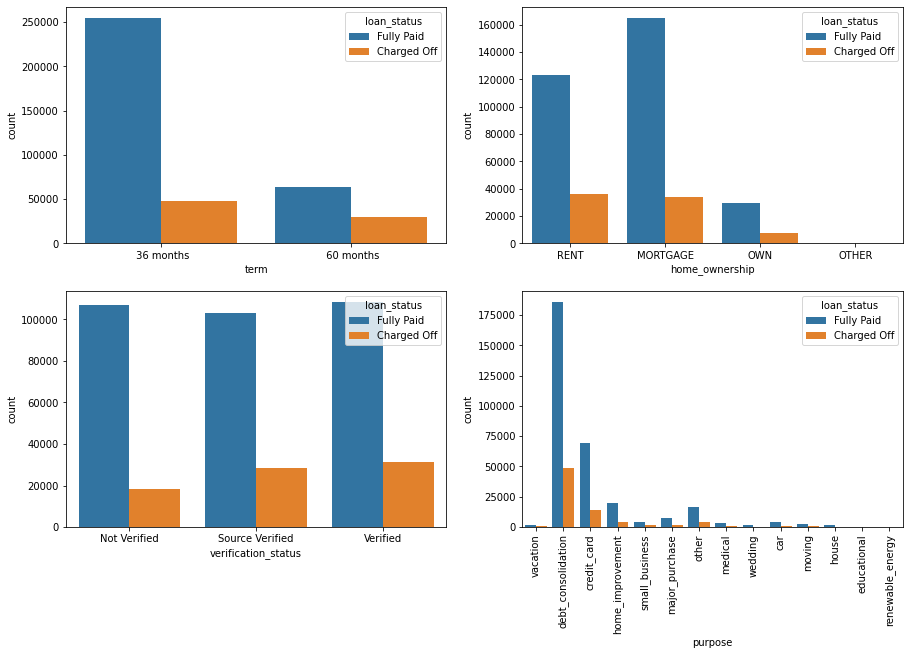

In [27]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.countplot(x='term',data=data,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=data,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=data,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=data,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)

Manager and Teacher are the most afforded loan on titles

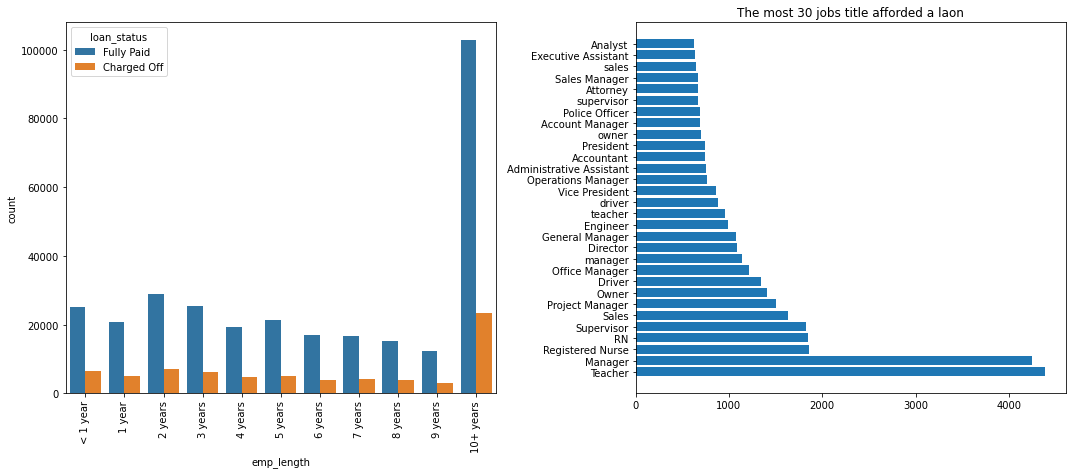

In [28]:
plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=data,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(data.emp_title.value_counts()[:30].index,data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

## Feature Engineering

In [29]:
data['pub_rec'].value_counts()

0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: pub_rec, dtype: int64

In [30]:
#below are high outlier columns. We dont want to delete these records since someone whos taken a loan for the first time may have low bankruptucy record
#so im just flagging anything more than 0 as 1

def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
    

In [31]:
data['pub_rec']=data.pub_rec.apply(pub_rec)
data['mort_acc']=data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies']=data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<AxesSubplot: xlabel='pub_rec_bankruptcies', ylabel='count'>

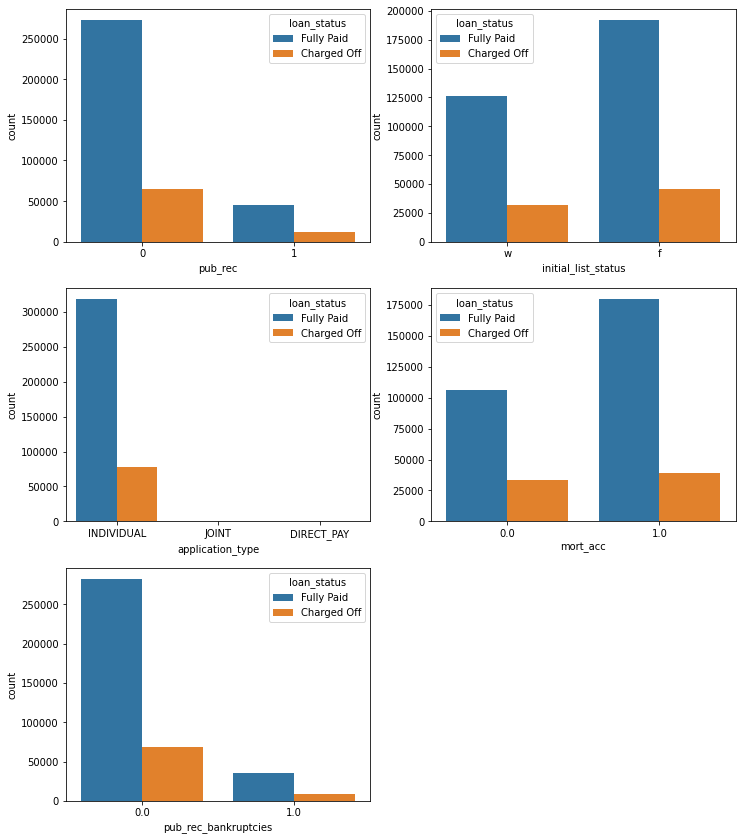

In [32]:
plt.figure(figsize=(12,30))

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=data,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=data,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=data,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=data,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=data,hue='loan_status')


In [33]:
# Mapping of target variable 
data['loan_status']=data.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [34]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

## Mean Target Imputaion

In [35]:
data.groupby(by='total_acc').mean()

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
total_acc,,,,,,,,,,,
2.0,6672.222222,15.801111,64277.777778,0.222222,2.279444,1.611111,0.000000,2860.166667,53.527778,0.000000,0.000000
3.0,6042.966361,15.615566,41270.753884,0.220183,6.502813,2.611621,0.033639,3382.807339,49.991022,0.046243,0.015480
4.0,7587.399031,15.069491,42426.565969,0.214055,8.411963,3.324717,0.033118,4874.231826,58.477400,0.062140,0.019672
5.0,7845.734714,14.917564,44394.098003,0.203156,10.118328,3.921598,0.055720,5475.253452,56.890311,0.090789,0.039187
6.0,8529.019843,14.651752,48470.001156,0.215874,11.222542,4.511119,0.076634,6546.374957,57.812483,0.121983,0.050947
...,...,...,...,...,...,...,...,...,...,...,...
124.0,23200.000000,17.860000,66000.000000,1.000000,14.040000,43.000000,0.000000,25497.000000,75.400000,1.000000,0.000000
129.0,25000.000000,7.890000,200000.000000,0.000000,8.900000,48.000000,0.000000,27659.000000,8.300000,1.000000,0.000000
135.0,24000.000000,15.410000,82000.000000,0.000000,33.850000,57.000000,0.000000,35715.000000,50.800000,1.000000,0.000000


In [36]:
# saving mean of mort_acc according to total_acc_avg
total_acc_avg=data.groupby(by='total_acc').mean().mort_acc


In [37]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [38]:
data['mort_acc']=data.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [39]:
data.isnull().sum()/len(data)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [40]:
# Current no. of rows
data.shape

(396030, 26)

In [41]:
# Dropping rows with null values
data.dropna(inplace=True)

In [42]:
# Remaining no. of rows
data.shape

(370622, 26)

## Outlier Detection & Treatment

In [43]:
numerical_data=data.select_dtypes(include='number')
num_cols=numerical_data.columns
len(num_cols)

12

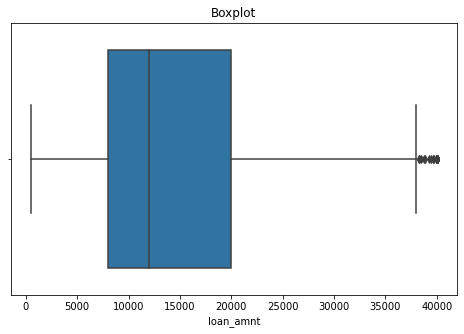

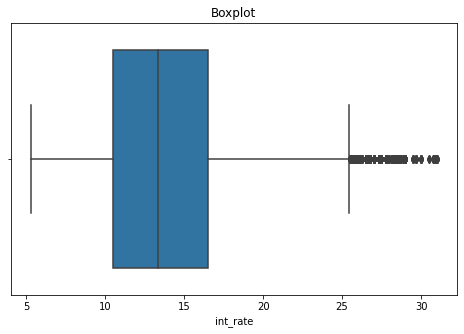

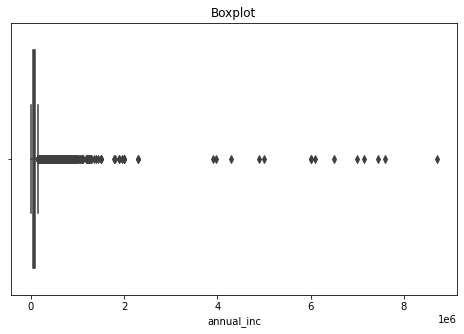

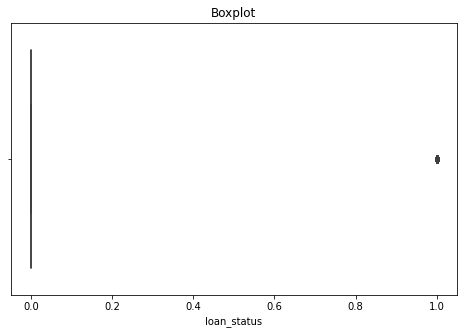

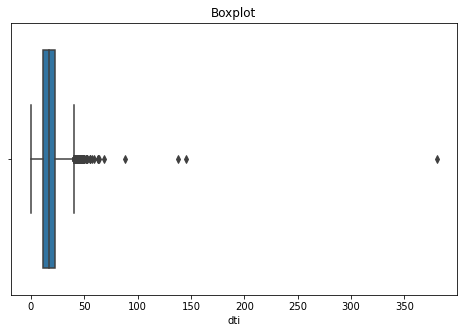

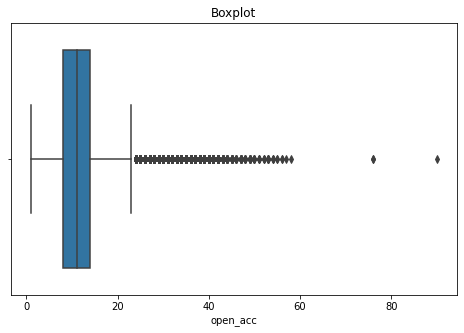

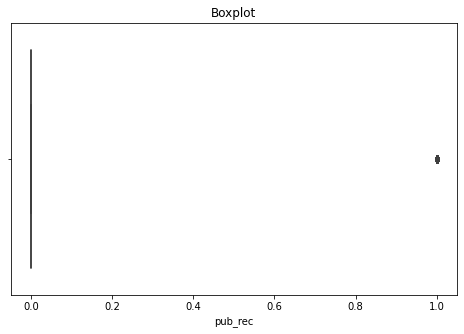

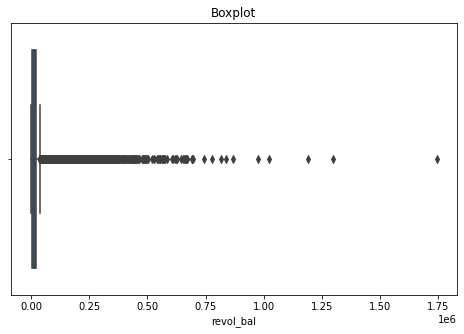

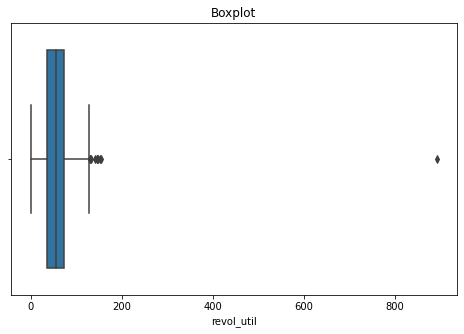

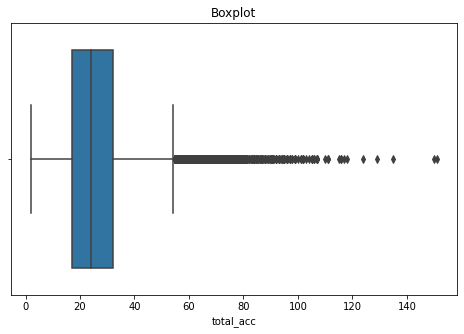

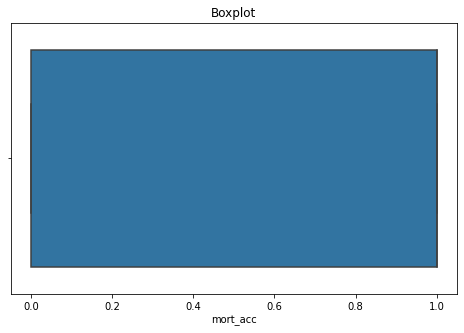

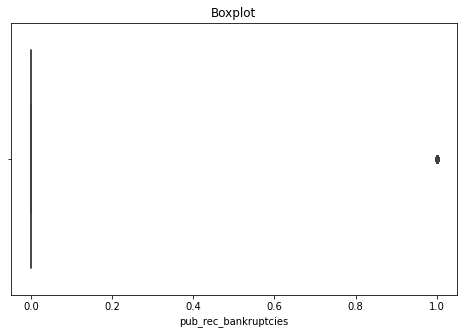

In [44]:
def box_plot(col):
    plt.figure(figsize=(8,5))
    sns.boxplot(x=data[col])
    plt.title('Boxplot')
    plt.show()
    
for col in num_cols:
    box_plot(col)

In [45]:
for col in num_cols:
    mean=data[col].mean()
    std=data[col].std()
    
    upper_limit=mean+3*std
    lower_limit=mean-3*std
    
    data=data[(data[col]<upper_limit) & (data[col]>lower_limit)]
    
data.shape

(354519, 26)

## Data Preprocesing

In [46]:
# Term
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [47]:
term_values={' 36 months': 36, ' 60 months':60}
data['term'] = data.term.map(term_values)

In [48]:
# Initial List Status
data['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [49]:
list_status = {'w': 0, 'f': 1}
data['initial_list_status'] = data.initial_list_status.map(list_status)

In [50]:
# Let's fetch ZIP from address and then drop the remaining details -
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [51]:
data['zip_code'].value_counts(normalize=True)*100

70466    14.382022
30723    14.277373
22690    14.268347
48052    14.127028
00813    11.610097
29597    11.537322
05113    11.516731
93700     2.774746
11650     2.772771
86630     2.733563
Name: zip_code, dtype: float64

In [52]:
# Dropping some variables which we can let go for now 
data.drop(columns=['issue_d', 'emp_title', 'title', 'sub_grade',
                   'address', 'earliest_cr_line', 'emp_length'], 
                   axis=1, inplace=True)

## One-hot Encoding

In [53]:
dummies=['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership']
data=pd.get_dummies(data,columns=dummies,drop_first=True)

In [54]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

data.head()

,loan_amnt,term,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,10000.0,36,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,25.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1,8000.0,36,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,27.0,1,1.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,15600.0,36,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,26.0,1,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
3,7200.0,36,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,13.0,1,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,24375.0,60,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,43.0,1,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0


In [55]:
data.shape

(354519, 49)

## Data Preparation for Modelling

In [56]:
X=data.drop('loan_status',axis=1)
y=data['loan_status']

In [57]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30,stratify=y,random_state=42)

In [58]:
print(X_train.shape)
print(X_test.shape)

(248163, 48)
(106356, 48)


#### MinMaxScaler -

For each value in a feature, MinMaxScaler subtracts the minimum value in the feature and then divides by the range. The range is the difference between the original maximum and original minimum.

MinMaxScaler preserves the shape of the original distribution. It doesn’t meaningfully change the information embedded in the original data.

In [59]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

In [60]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [61]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.890


## Confusion Matrix 

In [62]:
confusion_matrix=confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[85363   525]
 [11130  9338]]


## Classification Report

In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     85888
           1       0.95      0.46      0.62     20468

    accuracy                           0.89    106356
   macro avg       0.92      0.73      0.78    106356
weighted avg       0.90      0.89      0.87    106356



#### ROC Curve -

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

- True Positive Rate
- False Positive Rate

True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

- TPR=(TP)/(TP+FN)

False Positive Rate (FPR) is defined as follows:

- FPR=(FP)/(FP+TN) 

An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve.

#### AUC (Area under the ROC Curve) -

AUC stands for "Area under the ROC Curve." That is, AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral calculus) from (0,0) to (1,1).


AUC provides an aggregate measure of performance across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, given the following examples, which are arranged from left to right in ascending order of logistic regression predictions.

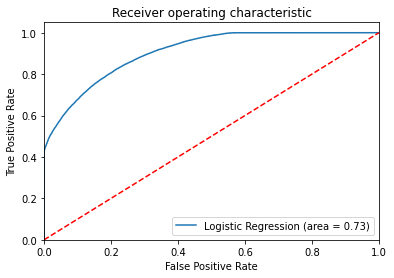

In [64]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

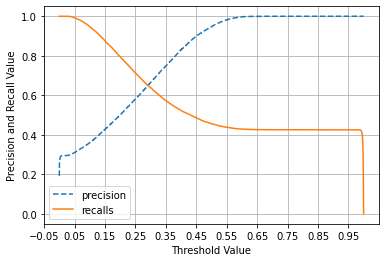

In [65]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')
    
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

### Multicollinearity check using Variance Inflation Factor (VIF) -

Multicollinearity occurs when two or more independent variables are highly correlated with one another in a regression model. Multicollinearity can be a problem in a regression model because we would not be able to distinguish between the individual effects of the independent variables on the dependent variable.

Multicollinearity can be detected via various methods. One such method is Variance Inflation Factor aka VIF.
In VIF method, we pick each independent feature and regress it against all of the other independent features.
VIF score of an independent variable represents how well the variable is explained by other independent variables.

VIF = 1/1-R2

In [66]:
def calc_vif(X):
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X.columns
    vif['VIF']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X)[:5]

,Feature,VIF
43,application_type_INDIVIDUAL,156.97
2,int_rate,122.82
14,purpose_debt_consolidation,51.00
1,term,27.30
13,purpose_credit_card,18.48


In [67]:
X.drop(columns=['application_type_INDIVIDUAL'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
2,int_rate,103.43
14,purpose_debt_consolidation,27.49
1,term,24.31
5,open_acc,13.75
9,total_acc,12.69


In [68]:
X.drop(columns=['int_rate'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
1,term,23.35
13,purpose_debt_consolidation,22.35
4,open_acc,13.64
8,total_acc,12.69
7,revol_util,9.06


In [69]:
X.drop(columns=['term'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
12,purpose_debt_consolidation,18.37
3,open_acc,13.64
7,total_acc,12.65
6,revol_util,9.04
1,annual_inc,8.03


In [70]:
X.drop(columns=['purpose_debt_consolidation'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
3,open_acc,13.09
7,total_acc,12.64
6,revol_util,8.31
1,annual_inc,7.70
2,dti,7.58


In [71]:
X.drop(columns=['open_acc'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
6,total_acc,8.23
5,revol_util,8.00
1,annual_inc,7.60
2,dti,7.02
0,loan_amnt,6.72


In [72]:
X=scaler.fit_transform(X)

kfold=KFold(n_splits=5)
accuracy=np.mean(cross_val_score(logreg,X,y,cv=kfold,scoring='accuracy',n_jobs=-1))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.891


# Tradeoff Questions:

## Question : How can we make sure that our model can detect real defaulters and there are less false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.

## Answer:  To keep very less False Positives, oversampling techniques like SMOTE should be used in model creation. Also we can use more complex algorithms like SVM, Decision-Trees, Random Forest and also try various hyperparameter tunning. As you can see from the data, the percentage of defaulters is slightly higher than Banking industry.


## Question : Since NPA (non-performing asset) is a real problem in this industry, it’s important we play safe and shouldn’t disburse loans to anyone.

## Answer : Yes. Company should not disburse loans to everyone. Company’s internal policy and analysis should be in place to identify the correct persons. From data provided, 20% of people default on their loan, which inturn become NPAs for the company.
## Low False positive means we should create the model with high Precision values. This can be achieved if we are keeping high threshold value in logistic Regression model.
##  But keeping too high values for threshold will increase False Negatives. This intuen may result in opportunity loss. In this case we will not give loans to persons which will not default but our model has predicted that they will default. 

## Oversampling using SMOTE

In [73]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())

In [74]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (400810, 48)
After OverSampling, the shape of train_y: (400810,) 

After OverSampling, counts of label '1': 200405
After OverSampling, counts of label '0': 200405


In [75]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)
  
# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     85888
           1       0.49      0.81      0.61     20468

    accuracy                           0.80    106356
   macro avg       0.72      0.80      0.74    106356
weighted avg       0.86      0.80      0.82    106356



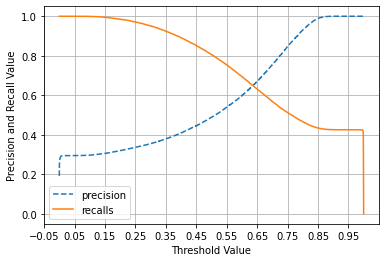

In [76]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])

# Actionable Insights & Recommendations:

- Around 80.26% of customers have fully paid their Loan Amount. The defaulters are ~ 20%. From Personal loan business perspective this ratio is high. These 20% will contribute in NPAs of Company. To reduce the risk of NPAs:
    * Company should add slightly stringent rules to bring down this ratio to 5% to 6%.
    * Company should provide loans at slightly higher rate than other Banks. This will offset the risks of defaulters and    maintain the profitability of the business.
- Overall Statistics of the Model:
    * Accuracy = 89%
    * Precision = 88 %
    * Recall = 99 %
    * F1 -score = 94%
- Model created has high values for accuracy, precision, recall & f1-score. This means, this model is a good classifier. Overall, it has good prediction capability in identifying right customers (which can be easily converted).
    * However this model has slightly low capability on correctly identifying defaulters. Overall data has 20% defaulters, model is able to predict 10% of them correctly.
    * Using this model, Company can easily reduce the ration of defaulters in their portfolio.

- Features which have significant impact on outcome are as follow:

    * int_rate: Interest Rate
    * sub_grade: loan subgrade
    * term : number of payments on the loan
    * home_ownership
    * purpose
    * application_type
    * pincode (from address)
    * emp_title: job title supplied by the Borrower
- sub_grade and grade logic to classify persons by Company is well created. From the model it is considered to be significant.
- pincode is significant feature.
    * Pincodes with Negative Coefficient: 93700, 11650, 86630, 48052, 30723, 70466, 22690
    * Pincodes with Positive Coefficient: 05113, 29597
    * Company can increase their market presence in Pincodes with Positive Coefficient.
    * Company should minimize their marketing/sales expenditure in Pincodes with Negative Coefficient.
    * Pincode based market segmentation should be included at strategic levels.
- emp_title Owner & Driver has negative Coefficient. emp_title Project Manager has positive Coefficient. Company can also decide their social media based marketing based on person's job-titles.
- application_type JOINT has positive Coefficient. Which means Company can promote persons to apply for joint loan. Because of this, chances of default will reduce.
- Purpose Renewable energy has negative Coefficient. This means Company should stick to giving loans to conventional purposes like Marriage, car etc.
- Term 60 months has negative Coefficient. Which means Company should focus more on Loans for shorter duration (i.e. 36 months). Their social media campaign and marketing strategy should be based on this consideration.